## Why bottom-up approach?

1. Experiment
2. Understand it by creating it
3. Tweak everything
4. Contribute
5. Correlate papers with code

## Training

1. Overfit
2, Reduce over-fitting
3. Visualize the inputs and outputs

### How to reduce overfitting? (in order of priority)

1. More data
2. Data augmentation
3. Generalizable architectures
4. Regularization
5. Reduce architecture complexity

> Read papers!

## Steps to modern CNN

**Matmul -> Relu/init -> FC forward -> FC backward -> Train loop -> Conv -> Optim -> Batch norm -> Resnet**

Build library in jupyter notebooks!

## Matrix Multiplication from scratch

Only modules/libraries allowed to use are :


- Python
- Python modules (non-DL)
- pytorch indexable tensor, and - tensor creation (including RNGs - random number generators)
- fastai.datasets

> **exp** is the folder where the python scripts will reside once they are exported from the Jupyter notebooks.


In [0]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!ls 'drive/My Drive/dl'

deep-learning-foundations.ipynb  exp  notebook2script.py  run_notebook.py


In [0]:
%cd 'drive/My Drive/dl/'

/content/drive/My Drive/dl


In [0]:
!pwd

/content/drive/My Drive/dl


## To do unit tests

In [0]:
# export 
from exp.nb_00 import *
import operator

# set up a unit test function 
def test(a,b,cmp,cname=None):
    if cname is None: cname=cmp.__name__
    assert cmp(a,b),f"{cname}:\n{a}\n{b}"

def test_eq(a,b): test(a,b,operator.eq,'==')

In [0]:
test_eq(TEST, 'test')

## Get the data

In [0]:
# export
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor

# MNIST in pickle (pkl) format
MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'

- In python the standard serialization version is **pickle**
- It gives a tuple of tuples

In [0]:
path = datasets.download_data(MNIST_URL, ext='.gz'); path

PosixPath('/root/.fastai/data/mnist.pkl.gz')

In [0]:
with gzip.open(path, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

In [0]:
x_train, y_train, x_valid, y_valid = map(tensor, (x_train, y_train, x_valid, y_valid))
# number of rows, columns
n, c = x_train.shape
x_train, x_train.shape, y_train, y_train.shape, y_train.min(), y_train.max()

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([50000, 784]),
 tensor([5, 0, 4,  ..., 8, 4, 8]),
 torch.Size([50000]),
 tensor(0),
 tensor(9))

In [0]:
assert n==y_train.shape[0]==50000
test_eq(c,28*28)
test_eq(y_train.min(),0)
test_eq(y_train.max(),9)

In [0]:
mpl.rcParams['image.cmap'] = 'gray'

In [0]:
img = x_train[0]

In [0]:
img.view(28,28).type()

'torch.FloatTensor'

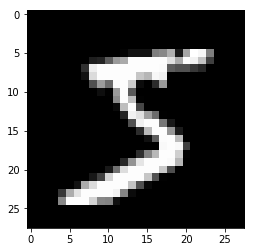

In [0]:
plt.imshow(img.view(28,28));

## Initial Python Model

- Creating a linear model : $y=ax+b$
- $a=weights$
- dimensions : 784x10
- $b=bias$
- dimensions : 10x1

In [0]:
weights = torch.randn(784,10); weights.size()

torch.Size([784, 10])

In [0]:
bias = torch.zeros(10)

### Matrix multiplication

- We will need three loops
- No of rows A = No of columns of B

In [0]:
def matmul(a,b):
    # n_rows, n_cols
    ar,ac = a.shape
    br,bc = b.shape
    assert ac==br # check
    c = torch.zeros(ar,bc) # resultant tensor/matrix
    for i in range(ar):
        for j in range(bc):
            for k in range(br): # or ac
                c[i,j] += a[i,k]*b[k,j]
    return c

In [0]:
m1 = x_valid[:5] # grab the first 5
m2 = weights

In [0]:
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [0]:
%time t1=matmul(m1,m2)

CPU times: user 814 ms, sys: 0 ns, total: 814 ms
Wall time: 819 ms


> So it took 819ms on vanilla python implementation.

It takes about a minute. We can speed up!

In [0]:
t1.shape

torch.Size([5, 10])

In [0]:
len(x_train)

50000

> Its going to take a great amount of time! Python is **SLOW**

- PyTorch uses A10 in the backend

### Elementwise operations

- +,-,*,/,>,<,== are elementwise

In [0]:
a = tensor([10.,6,-4])
b = tensor([2.,8,7])
a,b

(tensor([10.,  6., -4.]), tensor([2., 8., 7.]))

In [0]:
a+b

tensor([12., 14.,  3.])

In [0]:
(a<b).float().mean()

tensor(0.6667)

In [0]:
m = tensor([[1., 2, 3], [4,5,6], [7,8,9]]); m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

### Frobenius norm

$$\parallel{}A_F\parallel{} = (\sum_{i,j=1}^{N}|a_{ij}|^2)^{1/2}$$
- It is quite important
- sum of two for loops i, j
- We square $a_{ij}$ and add all of them and then take sqrt

> Note : Or on arxiv.org, click "Download: Other formats" in the top right, then "Download source"; rename the downloaded file to end in .tgz if it doesn't already, and you should find the source there, including the equations to copy and paste.

In [0]:
(m*m).sum().sqrt()

tensor(16.8819)

### Elementwise matmul

In [0]:
def matmul(a,b):
    # n_rows, n_cols
    ar,ac = a.shape
    br,bc = b.shape
    assert ac==br # check
    c = torch.zeros(ar,bc) # resultant tensor/matrix
    for i in range(ar):
        for j in range(bc):
            # no need for 3rd loop (k)
            c[i,j] = (a[i,:]*b[:,j]).sum()
    return c

- `c[i,j] = (a[i,:]*b[:,j]).sum()` runs on **C (language)**

In [0]:
%timeit -n 10 _=matmul(m1,m2)

10 loops, best of 3: 1.57 ms per loop


To check how much the speedup was

In [122]:
819/1.57

521.656050955414

> There was a 500x speedup from vanilla python

To check if its right (floats slightly differ) with some level of tolerance we define a function

In [0]:
#export 
def near(a,b): return torch.allclose(a,b, rtol=1e-3, atol=1e-5)
def test_near(a,b): test(a,b,near)

In [0]:
test_near(t1, matmul(m1,m2))

## Broadcasting

- Running code on python and runs near C/CUDA speeds
- Idea comes from APL (1962)
- The term broadcasting describes how arrays with different shapes are treated during arithmetic operations. The term broadcasting was first used by Numpy.
- Subject to certain 
constraints, the smaller array is “broadcast” across the larger 
array so that they have compatible shapes. Broadcasting provides a 
means of vectorizing array operations so that looping occurs in C
instead of Python. It does this without making needless copies of 
data and usually leads to efficient algorithm implementations.
- In addition to the efficiency of broadcasting, it allows developers to write less code, which typically leads to fewer errors.

In [0]:
a

tensor([10.,  6., -4.])

### Broadcasting : Scalar (rank 0) to Vector (rank 1)

In [0]:
a > 0

tensor([1, 1, 0], dtype=torch.uint8)

- Here the value 0 is broadcasted 3 times i.e. `[0, 0, 0]` and then elementwise comparison takes place.
- A scalar is broadcasted to vector in this case
- How are we able to do a > 0? 0 is being broadcast to have the same dimensions as a.
- **Normalization** : For instance you can normalize our dataset by subtracting the mean (a scalar) from the entire data set (a matrix) and dividing by the standard deviation (another scalar), using broadcasting.

In [0]:
a + 1

tensor([11.,  7., -3.])

In [0]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [0]:
2*m

tensor([[ 2.,  4.,  6.],
        [ 8., 10., 12.],
        [14., 16., 18.]])

> Anytime we broadcast we are operating at C/CUDA speeds not python.

### Broadcasting : Vector (rank 1) to Matrix (rank 2)

In [0]:
c = tensor([10.,20,30]); c

tensor([10., 20., 30.])

In [0]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [0]:
c.size(), m.size()

(torch.Size([3]), torch.Size([3, 3]))

In [0]:
m + c

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

So it broadcasted c into a 3x3 matrix (with repeating rows)

In [0]:
c + m

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

> We don't really copy the rows, but it looks as if we did. In fact, the rows are given a stride of 0.

Lets see what c would look like when broadcasted to m,

In [0]:
t = c.expand_as(m); t

tensor([[10., 20., 30.],
        [10., 20., 30.],
        [10., 20., 30.]])

In [0]:
m + t

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

Lets check the storage,

In [0]:
t.storage()

 10.0
 20.0
 30.0
[torch.FloatStorage of size 3]

In [0]:
t.shape

torch.Size([3, 3])

In [0]:
t.stride()

(0, 1)

> Stride tells us that when it goes col to col it should take 1 step but from row to row it should take 0 steps through the storage!

- Broadcasting gives us C-like speed with no additional memory overhead.
- You can index with the special value [None] or use unsqueeze() to convert a 1-dimensional array into a 2-dimensional array (although one of those dimensions has value 1).

In [0]:
c.unsqueeze(0)

tensor([[10., 20., 30.]])

In [0]:
c.unsqueeze(1)

tensor([[10.],
        [20.],
        [30.]])

In [0]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [0]:
c.shape, c.unsqueeze(0).shape,c.unsqueeze(1).shape

(torch.Size([3]), torch.Size([1, 3]), torch.Size([3, 1]))

In [0]:
c.shape, c[None].shape,c[:,None].shape

(torch.Size([3]), torch.Size([1, 3]), torch.Size([3, 1]))

> You can always skip trailling ':'s. And '...' means 'all preceding dimensions'. Useful if the rank of the tensor would vary.


In [0]:
c[None].shape, c[...,None].shape

(torch.Size([1, 3]), torch.Size([3, 1]))

In [0]:
c[:, None].expand_as(m)

tensor([[10., 10., 10.],
        [20., 20., 20.],
        [30., 30., 30.]])

- Its getting broadcasted along the columns instead of rows 

In [0]:
m + c[:, None]

tensor([[11., 12., 13.],
        [24., 25., 26.],
        [37., 38., 39.]])

In [0]:
c[:, None]

tensor([[10.],
        [20.],
        [30.]])

In [0]:
c[None,...]

tensor([[10., 20., 30.]])

### Matmul with broadcasting

In [0]:
def matmul(a,b):
    # n_rows, n_cols
    ar,ac = a.shape
    br,bc = b.shape
    assert ac==br # check
    c = torch.zeros(ar,bc) # resultant tensor/matrix
    for i in range(ar):
        # no need for 2nd loop (j)
        # alternatively
        # c[i] = (a[i, :, None]*b).sum(0)
        c[i] = (a[i].unsqueeze(-1) * b).sum(dim=0)
    return c

In [0]:
%timeit -n 10 _=matmul(m1,m2)

10 loops, best of 3: 298 µs per loop


In [123]:
819000/298

2748.3221476510066

> 2700x speedup from vanilla python!

### Broadcasting rules

In [0]:
c[None, :].shape # inserting a preceding axis

torch.Size([1, 3])

In [0]:
c[:, None].shape # inserting a leading axis

torch.Size([3, 1])

In [0]:
c[None, :] * c[:, None]

tensor([[100., 200., 300.],
        [200., 400., 600.],
        [300., 600., 900.]])

Broadcasts the first one to match the second's shape and vice versa.

In [0]:
c[None] > c[:,None]

tensor([[0, 1, 1],
        [0, 0, 1],
        [0, 0, 0]], dtype=torch.uint8)

> 

When operating on two arrays/tensors, Numpy/PyTorch compares their shapes element-wise. It starts with the trailing dimensions, and works its way forward. Two dimensions are compatible when

- they are equal, or
- one of them is 1, in which case that dimension is broadcasted to make it the same size

Arrays do not need to have the same number of dimensions. For example, if you have a `256*256*3` array of RGB values, and you want to scale each color in the image by a different value, you can multiply the image by a one-dimensional array with 3 values. Lining up the sizes of the trailing axes of these arrays according to the broadcast rules, shows that they are compatible:

Image  (3d array): 256 x 256 x 3
Scale  (1d array):             3
Result (3d array): 256 x 256 x 3

The numpy documentation includes several examples of what dimensions can and can not be broadcast together.


### Einstein Summation



Einstein summation (einsum) is a compact representation for combining products and sums in a general way. From the numpy docs:

"The subscripts string is a comma-separated list of subscript labels, where each label refers to a dimension of the corresponding operand. Whenever a label is repeated it is summed, so np.einsum('i,i', a, b) is equivalent to np.inner(a,b). If a label appears only once, it is not summed, so np.einsum('i', a) produces a view of a with no changes."


In [0]:
# How we convert to einsum notation :
# 1. c[i,j] += a[i,k] * b[k,j]
# 2. a[i,k] * b[k,j] -> c[i,j]
# 3. ik,kj->ij

def matmul(a,b): return torch.einsum('ik,kj->ij', a, b)

- no of inputs delimited by comma
- rank of each input is equal to number of inputs i.e. ik, kj abd ij are all 

In [110]:
%timeit -n 10 _=matmul(m1,m2)

The slowest run took 83.14 times longer than the fastest. This could mean that an intermediate result is being cached.
10 loops, best of 3: 46.9 µs per loop


> It took just **`46.9 µs`**!

In [111]:
885000/46.9

18869.93603411514

> Its 18x faster than vanilla python

In [0]:
test_near(t1, matmul(m1,m2))

### PyTorch op

In [113]:
%timeit -n 10 t2 = m1.matmul(m2)

The slowest run took 83.12 times longer than the fastest. This could mean that an intermediate result is being cached.
10 loops, best of 3: 9.27 µs per loop


In [126]:
819000/9.27

88349.5145631068

> Its 88x faster than python now!

- BLAS : Basic linear algebra subprograms
- PyTorch pushes to BLAS
- Nvidia's version : CuBLAS
- Intel's version : MKL

In [0]:
# @ is an operand used for matrix multiplication 
t2 = m1@m2 

In [0]:
test_near(t1,t2)

### Exporting .ipynb to .py scripts

In [0]:
!pip install fire
!python notebook2script.py matmul.ipynb